In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11/chains???.hdf5'))

print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris())
    all_times.extend(m.lc.times.jd)

    spots = m.get_spots()
    transits.append(Transit(spots, time=m.lc.times.jd.mean()))

load results


spots: 362


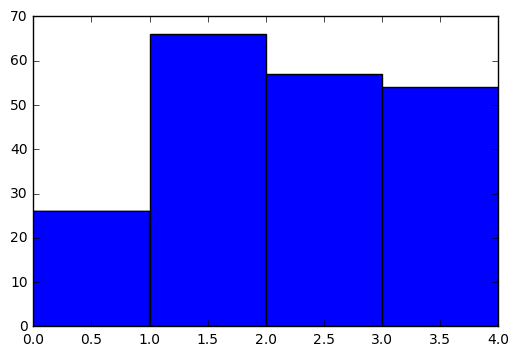

In [6]:
bic_threshold = 20

spots_per_transit = np.zeros(len(transits))
times_each_transit = np.zeros(len(transits))
n_spots = 0
for i, transit in enumerate(transits):
    for spot in transit.spots:
        if spot.delta_BIC > bic_threshold:
            spots_per_transit[i] += 1
            n_spots += 1
    if times_each_transit[i] == 0:
        times_each_transit[i] = transit.time

print('spots: {0}'.format(n_spots))
plt.hist(spots_per_transit, 4);

In [22]:
half_way_point = times_each_transit[0] + times_each_transit.ptp()/2

first_half = times_each_transit < half_way_point
second_half = times_each_transit > half_way_point

N_first_half = np.sum(spots_per_transit[first_half])
N_second_half = np.sum(spots_per_transit[second_half])

print("First half: {} {}".format(N_first_half, np.sqrt(N_first_half)))
print("Second half: {} {}".format(N_second_half, np.sqrt(N_second_half)))

First half: 190.0 13.7840487521
Second half: 172.0 13.1148770486


For a Poisson distribution

$$ f(k; \lambda)=\frac{\lambda^k e^{-\lambda}}{k!}$$

the log-likelihood is

$$ \mathcal{L}(x, \lambda(t)) = \Sigma_i \left( x_i \log\lambda - \lambda \right) $$

where we parameterize the Poisson rate parameter $\lambda$ as a linear function of time with two hyperparameters $\lambda_0, \lambda_1$

$$\lambda(t) = \lambda_0 t + \lambda_1$$

In [114]:
import emcee

def lnprior(theta, x):
    m, b = theta
    if (-1 < m < 1) and b > 0 and np.all(m*x + b > 0):
        return 0.0
    return -np.inf

def lnlike(theta, x, y):
    m, b = theta
    lam = m * x + b
    
    # http://mathworld.wolfram.com/MaximumLikelihood.html
    return np.sum(y * np.log(lam) - lam)

def lnprob(theta, x, y):
    lp = lnprior(theta, x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

args = (times_each_transit, spots_per_transit)

/astro/apps6/opt/anaconda2.0/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log


In [144]:
ndim, nwalkers = 2, 6
pos = [np.array([0.0, 2]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(times_each_transit - times_each_transit[0], spots_per_transit))


In [188]:
N_steps = 15000
N_burnin = 10000
sampler.run_mcmc(pos, N_steps);

In [189]:
samples = sampler.chain[:, N_burnin:, :].reshape((-1, ndim))

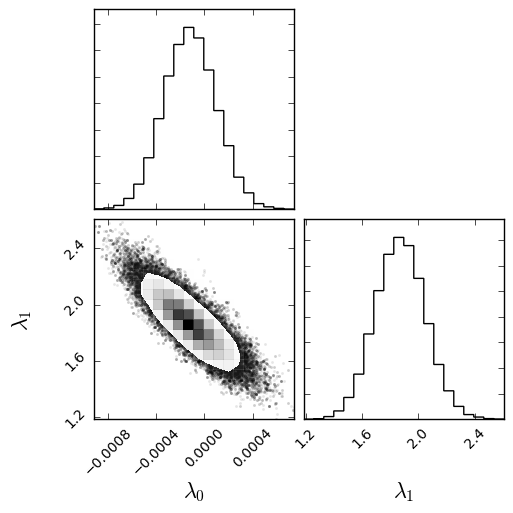

In [235]:
import corner

corner.corner(samples, labels=['$\lambda_0$', '$\lambda_1$'], label_kwargs=dict(fontsize=16))
plt.show()

In [191]:
prob_slope_negative = np.count_nonzero(samples[:, 0] < 0) / float(samples[:,0].size)

print('Probability slope is negative: {}'.format(prob_slope_negative))

Probability slope is negative: 0.705711111111


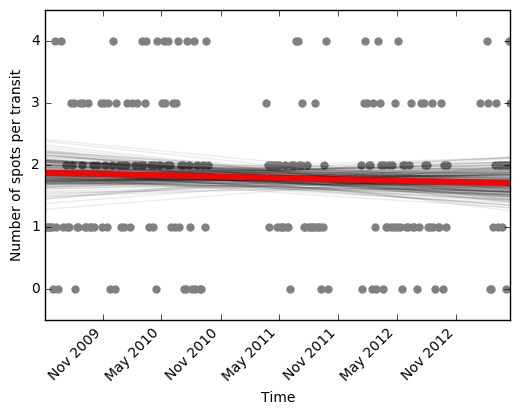

In [200]:
from astropy.time import Time

fig, ax = plt.subplots()
ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
              spots_per_transit, 'o', color='gray', mec='none')

n_random_samples = 200
for i in range(n_random_samples):
    ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
                  np.polyval(samples[np.random.randint(samples.shape[0])], 
                             times_each_transit - times_each_transit[0]), 
                  ls='-', markersize=0, color='k', alpha=0.08)

def best_fit_model(times):
    return np.polyval(np.median(samples, axis=0), times)
    
ax.plot_date(Time(times_each_transit, format='jd').plot_date, 
              best_fit_model(times_each_transit - times_each_transit[0]), 
              ls='-', markersize=0, color='r', lw=4)
    
ax.set_xlabel('Time')
ax.set_ylabel('Number of spots per transit')
ax.set_ylim([-0.5, 4.5])

for l in ax.get_xticklabels():
    l.set_rotation(45)
    l.set_ha('right')

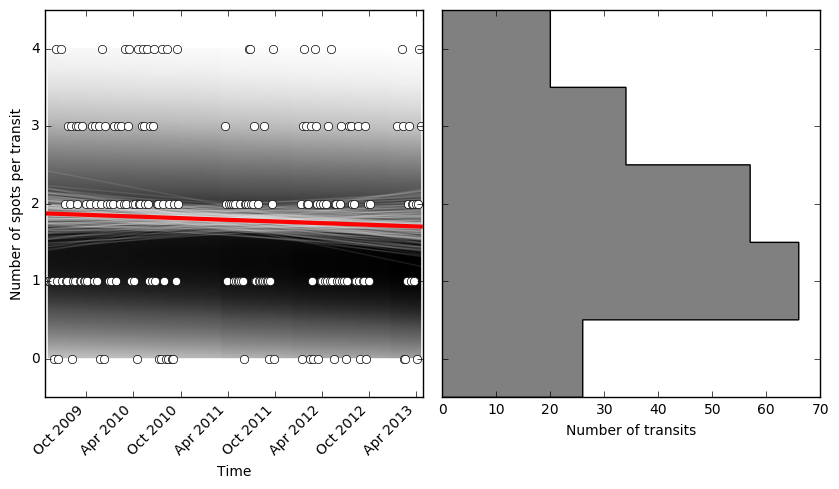

In [315]:
from scipy.misc import factorial

n_bins = 100

dist = np.zeros((n_bins, len(spots_per_transit)))

def poisson(k, lam):
    return (lam**k * np.exp(-lam)) / factorial(k)

for i in range(len(spots_per_transit)):
    dist[:, i] = poisson(np.linspace(0, 4, n_bins), 
                         best_fit_model(times_each_transit[i] - times_each_transit[0]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

first_time = Time(times_each_transit, format='jd').plot_date[0]
last_time = Time(times_each_transit, format='jd').plot_date[-1]
ax[0].imshow(dist, extent=[first_time, last_time, 0, 4], 
          cmap=plt.cm.Greys, origin='lower')#, interpolation='nearest')

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of spots per transit')
ax[0].set_ylim([-0.5, 4.5])
ax[0].set_aspect(300)

n_random_samples = 200
for i in range(n_random_samples):
    ax[0].plot_date(Time(times_each_transit, format='jd').plot_date, 
                    np.polyval(samples[np.random.randint(samples.shape[0])], 
                               times_each_transit - times_each_transit[0]), 
                    ls='-', markersize=0, color='w', alpha=0.1)

ax[0].plot_date(Time(times_each_transit, format='jd').plot_date, 
                best_fit_model(times_each_transit - times_each_transit[0]), 
                ls='-', markersize=0, color='r', lw=3)

ax[0].plot_date(Time(times_each_transit, format='jd').plot_date, 
                spots_per_transit, 'o', color='w', mec='k')

ax[0].set_xlim([first_time, last_time])


for l in ax[0].get_xticklabels():
    l.set_rotation(45)
    l.set_ha('right')

bin_edges = np.arange(0, 6) - 0.5
ax[1].hist(spots_per_transit, bins=bin_edges, orientation='horizontal',
           histtype='stepfilled', color='gray')
ax[1].set_xlabel('Number of transits')
fig.subplots_adjust(wspace=0.05)
#ax[1].set_ylabel('Number of spots per transit')

**Figure X**: The number of significant ($\Delta$BIC>20) spots per transit throughout the Kepler mission (white dots). The shading corresponds to the maximum likelihood Poisson distribution as defined in Eqn XX. The red line is the maximum likelihood Poisson rate parameter $\lambda(t) = \lambda_0 t + \lambda_1$, and the white lines are samples from the rate parameter posterior distributions. 